# SQLite

In [7]:
from ipywidgets import widgets
from IPython.display import display
import time
import json
import os
import pandas as pd
import glob
from sqlalchemy import create_engine
import string
import re
import contractions
from emoji import UNICODE_EMOJI
string.punctuation
import nltk

def remove_Atsign(text):
    """Remove at sign from the input Text"""
    return re.sub(r"@\S+", "", text)

def remove_URL(text):
    """Remove URL from the input Text"""
    return re.sub(r"http\S+", "", text)

def remove_Contraction(text):
    """Remove Contraction from the input Text"""
    try:
        text = contractions.fix(text)
    except:
        pass
    return(text)

def remove_Emoji(text):
    """Remove Emoji"""
    return ''.join(c for c in text if c not in UNICODE_EMOJI['en'])

def remove_GUID(text):
    """Remove URL from the input Text"""
    return re.sub(r"[0-9a-f]{8}-[0-9a-f]{4}-[1-5][0-9a-f]{3}-[89ab][0-9a-f]{3}-[0-9a-f]{12}", "", text)

def remove_Numbers(text):
    """Remove Numbers from the input Text"""
    remove_digits = str.maketrans('', '', string.digits)
    return(text.translate(remove_digits))

def remove_Punctuation(text):
    """Remove Punctuation from the input Text"""
    """!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~"""
    text_punctuated = "".join([char for char in text if char not in string.punctuation])
    return text_punctuated

def user_id(user):
    try:
        return(user['id'])
    except:
        pass

def user_location(user):
    try:
        return(user['location'])
    except:
        pass

def extended_tweet(extended):
    try:
        return(extended['full_text'])
    except:
        pass

def user_description(user):
    try:
        if (user['description']):
            return(' ' + user['description'])
        else:
            return(' 0')
    except:
        pass

def tokenize_data(text):
    """Tokenizing input text"""
    tokens = re.split('\W+', text.lower())
    return tokens

def remove_Stopwords(text):
    """Removing Stops words"""
    stopwords = nltk.corpus.stopwords.words('english')
    #Adding additional words to the list of stop words to remove them
    #addition_StopWords = []
    #stopwords.extend(addition_StopWords)
    text_stopwords = [word for word in text if word not in stopwords]
    return(text_stopwords)

def lemmatizing(text):
    """Lemmatizing the input text using WordNet and NLTK package"""
    NLTK_WNL = nltk.WordNetLemmatizer()
    text_Lem = [NLTK_WNL.lemmatize(word) for word in text]
    return(text_Lem)

def tweet_cleaning(text):
    """Cleaning and Lemmatizing Tweets"""
    text = remove_URL(text)
    text = remove_Atsign(text)
    text = remove_Emoji(text)
    text = remove_GUID(text)
    text = remove_Numbers(text)
    text = remove_Contraction(text)
    text = remove_Punctuation(text)
    text = tokenize_data(text)
    text = remove_Stopwords(text)
    text = lemmatizing(text)
    return(text)

    
datastore_Path = "D:/F-drive-31578/Twitter-2020-12/All"
tweet_Cols = ['u_id', 'u_location', 'tweet', 'retweeted', 'geo', 'coordinates', 'place']
#tweet_Cols = ['u_id', 'u_location', 'u_description', 'id', 'text', 'retweeted', 'geo', 'coordinates', 'place', 'extended_tweet']

df_List = [] #An empty list to keep DataFrames
json_Filelist = glob.glob(os.path.join(datastore_Path, '*.json'))


prog = widgets.IntProgress(continuous_update=False, min=0, max=len(json_Filelist), 
                            description=  '0/' + str(len(json_Filelist)) + '  ', orientation='horizontal',
                            style={'bar_style': 'success'})# instantiate the bar
display(prog)# display the bar

#db = sqlite3.connect("F:/Tweets/Tweets.sqlite")
engine = create_engine('sqlite:///C:\Tweets\\Tweets_clean.db', echo = False)
sqlite_connection = engine.connect()

for file in json_Filelist:
    try:
        df_Temp = pd.read_json(file, lines=True)
    
        df_Temp = df_Temp[df_Temp['lang'] == 'en']
        df_Temp['u_id'] = df_Temp['user'].apply(lambda x: user_id(x))

        df_Temp['u_location'] = df_Temp['user'].apply(lambda x: user_location(x))
        df_Temp = df_Temp[df_Temp['u_location'].notnull()]

        df_Temp = df_Temp[df_Temp['extended_tweet'].notnull()]
        df_Temp['extended_tweet'] = df_Temp['extended_tweet'].apply(lambda x: extended_tweet(x))

        df_Temp['u_description'] = df_Temp['user'].apply(lambda x: user_description(x))

        #df_Temp['u_description'] = df_Temp['u_description'].apply(lambda x: tweet_cleaning(x))
        #df_Temp['extended_tweet'] = df_Temp['extended_tweet'].apply(lambda x: tweet_cleaning(x))
        df_Temp['tweet'] = df_Temp['extended_tweet'] + df_Temp['u_description']
        df_Temp['tweet'] = df_Temp['tweet'].apply(lambda x: tweet_cleaning(x))

        df_Temp[tweet_Cols].astype(str).to_sql("Tweets", sqlite_connection, if_exists="append")
        prog.value += 1 # signal to increment the progress bar
        prog.description =  str(prog.value) + '/' + str(len(json_Filelist)) + '  '
    except:
        pass
 
sqlite_connection.close()

IntProgress(value=0, description='0/43736  ', max=43736)

In [6]:
sqlite_connection.close()

In [129]:
from sqlalchemy import create_engine
import pandas as pd
import re

def lat(geo):
    res = (geo[geo.find('[')+1:geo.find(']')]).split(',')[0]
    return(float(res))

def long(geo):
    res = (geo[geo.find('[')+1:geo.find(']')]).split(',')[1]
    return(float(res))

engine = create_engine('sqlite:///C:\Tweets\\Tweets_clean.db', echo = False)
sqlite_connection = engine.connect()
query = "SELECT * FROM tweets where geo like '%%coordinates%'"
df = pd.read_sql(query, sqlite_connection)
sqlite_connection.close()

df['lat'] = df['geo'].apply(lambda x: lat(x))
df['long'] = df['geo'].apply(lambda x: long(x))

#df[['lat','long']].head()
#df = df.head()

In [126]:
df.head()

,index,u_id,u_location,tweet,retweeted,geo,coordinates,place,lat,long
0,1466,274070342,California,"['looking', 'nurse', 'practitioner', 'position...",0.0,"{'type': 'Point', 'coordinates': [38.5815719, ...","{'type': 'Point', 'coordinates': [-121.4943996...","{'id': 'b71fac2ee9792cbe', 'url': 'https://api...",38.5815719,-121.4943996
1,1890,495476008,"Newark, NJ","['value', 'highenergy', 'people', 'entrepreneu...",0.0,"{'type': 'Point', 'coordinates': [40.6975898, ...","{'type': 'Point', 'coordinates': [-74.2631635,...","{'id': 'e4faa50d904ab815', 'url': 'https://api...",40.6975898,-74.2631635
2,2892,423936363,"Apache Junction, AZ","['', 'fhilo', 'feel', 'like', 'f', 'wind', 'e'...",0.0,"{'type': 'Point', 'coordinates': [33.41578, -1...","{'type': 'Point', 'coordinates': [-111.49328, ...","{'id': 'bf09d4c99c2d845c', 'url': 'https://api...",33.41578,-111.49328
3,1948,118562628,Pennsylvania,"['recommend', 'anyone', 'installationmaintenan...",0.0,"{'type': 'Point', 'coordinates': [41.3259134, ...","{'type': 'Point', 'coordinates': [-75.7893604,...","{'id': '2ad6133c9988753b', 'url': 'https://api...",41.3259134,-75.7893604
4,1969,193979061,"Columbus, OH","['want', 'work', 'labcorp', 'hiring', 'dublin'...",0.0,"{'type': 'Point', 'coordinates': [40.0992294, ...","{'type': 'Point', 'coordinates': [-83.1140771,...","{'id': '2cb954ccdc0dba5f', 'url': 'https://api...",40.0992294,-83.1140771


# Map

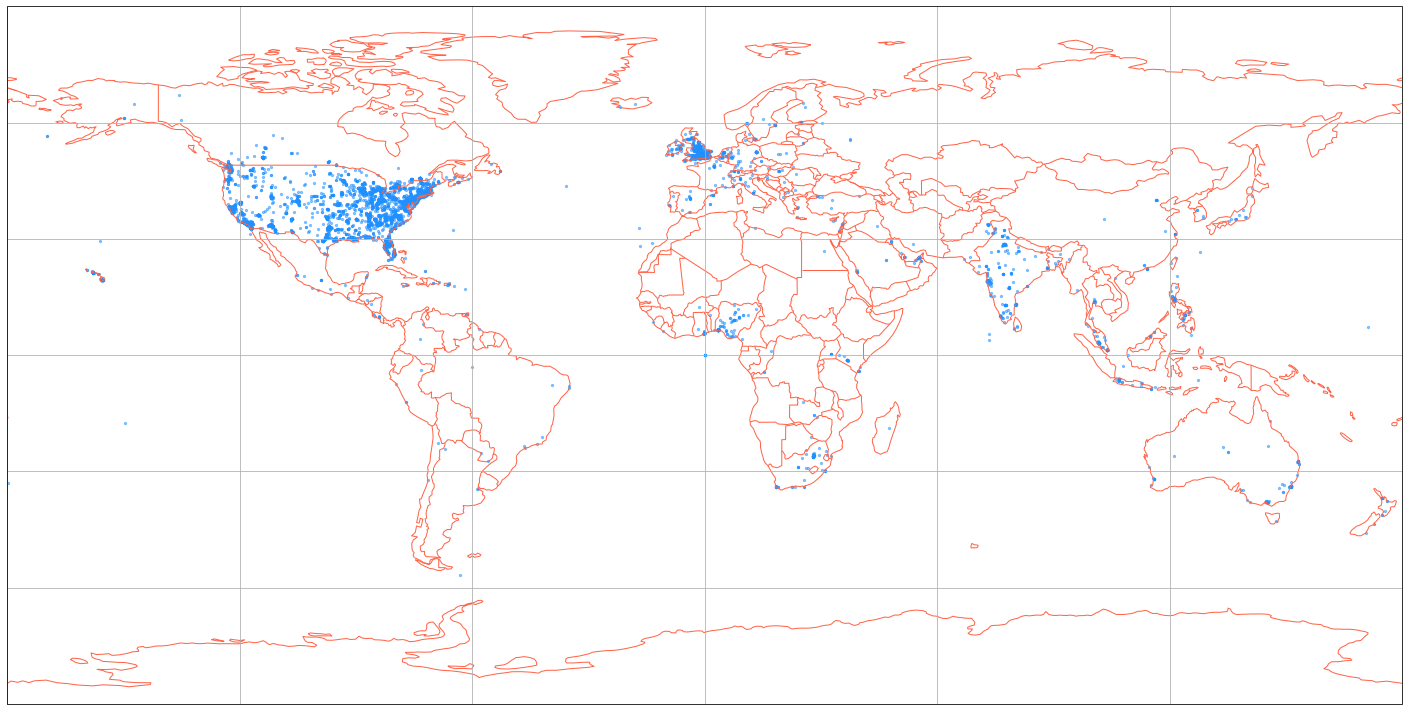

In [131]:
import matplotlib.pyplot as plt
import cartopy.crs as crs
import cartopy.feature as cfeature

fig = plt.figure(figsize=(25,40))

#ax = fig.add_subplot(1,1,1, projection=crs.Robinson())
ax = fig.add_subplot(1,1,1, projection=crs.PlateCarree())

ax.set_global()
#ax.stock_img()

ax.add_feature(cfeature.COASTLINE, edgecolor="tomato")
ax.add_feature(cfeature.BORDERS, edgecolor="tomato")
ax.gridlines()

plt.scatter(x=df.long, y=df.lat,
            color="dodgerblue",
            s=5,
            alpha=0.5,
            transform=crs.PlateCarree()) ## Important

plt.show()